# Activity recognition on the Capture24 dataset

## Training on the spectrogram of the signal

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

Computing the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of a
signal is a common visualization method in signal processing to treat
signals as 2D images. Recent works have looked at using the spectrogram
for classification, thus converting the signal recognition task into an image
recognition one and leveraging techniques from computer vision.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
# from tqdm import tqdm
from tqdm.notebook import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

 ###### Grab a GPU if there is one 

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


 ###### Load dataset and hold out some instances for testing 

In [3]:
data = np.load('capture24.npz', allow_pickle=True)
# data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
y, pid, time = data['y'], data['pid'], data['time']
X = np.load('X_raw.npy', mmap_mode='r')
# X = np.load('X_raw_small.npy')
print("Raw dataset shape:", X.shape)

# Hold out some participants for testing the model
pids_test = [2, 3]
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
y_train, y_test = y[mask_train], y[mask_test]
pid_train, pid_test = pid[mask_train], pid[mask_test]
# X[mask_train] and X[mask_test] if you like to live dangerously
X_train = utils.ArrayFromMask(X, mask_train)
X_test = utils.ArrayFromMask(X, mask_test)
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Raw dataset shape: (330610, 3, 3000)
Shape of X_train (325619, 3, 3000)
Shape of X_test (4991, 3, 3000)


 ###### Visualization

Let's visualize the spectrograms of the acceleration norm for each activity class.
We use
[scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html).
Here, the arguments `nperseg` and `noverlap` determine the size of the
resulting spectrogram. For `nperseg=120` and `noverlap=72`, the spectrogram
size is $61\times 61$.

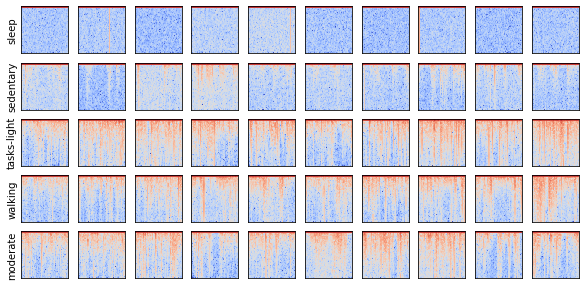

In [4]:
# Spectrogram parameters
N_FFT = 120
HOP_LENGTH = 48
WINDOW = 'hann'

NUM_PLOTS = 10
fig, axs = plt.subplots(utils.NUM_CLASSES, NUM_PLOTS, figsize=(10,5))
for i in range(utils.NUM_CLASSES):
    axs[i,0].set_ylabel(utils.CLASSES[i])
    idxs = np.where(y==i)[0]
    for j in range(NUM_PLOTS):
        _, _, z = scipy.signal.stft(
            np.linalg.norm(X[idxs[j]], axis=0),  # acceleration vector norm
            nperseg=N_FFT,
            noverlap=N_FFT-HOP_LENGTH,
            window=WINDOW,
            boundary=None, padded=False
        )
        z = np.log(np.abs(z) + 1e-16)
        axs[i,j].imshow(z, cmap='coolwarm')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.show()
fig.savefig('spectrogram.png')

 ## Classifying spectrograms for activity recognition

The rest of this notebook is identical to the previous notebook on neural
networks except for the model architecture which now uses 2D convolutions and
expects images, and the data loader that generates the spectrograms.

###### Architecture design

As a baseline model, we use a convolutional neural network (CNN) with a
typical pyramid-like structure. The input to the network is a `(N,3,61,61)`
array, corresponding to `N` spectrograms of the accelerometer signals.
The output of the network is a `(N,5)` array, each row containing predicted
*unnormalized class scores*.
To obtain probabilities, we can pass each row to a softmax. Then to report a
class label, we can pick the highest probability in each row. We output class
scores instead of class probabilities or labels because the loss function
that we will use operates on the scores [(torch.CrossEntropyLoss)](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

In [5]:
class ConvBNReLU(nn.Module):
    ''' Convolution + batch normalization + ReLU is a common trio '''
    def __init__(
        self, in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.main(x)

class CNN(nn.Module):
    ''' Typical CNN design with pyramid-like structure '''
    def __init__(self, output_size=5, in_channels=3, num_filters_init=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init,
            3, 2, 1, bias=False),  # 61x61 -> 31x31
            ConvBNReLU(num_filters_init, num_filters_init*2,
            3, 2, 1, bias=False),  # 31x31 -> 16x16
            ConvBNReLU(num_filters_init*2, num_filters_init*4,
            4, 2, 1, bias=False),  # 16x16 -> 8x8
            ConvBNReLU(num_filters_init*4, num_filters_init*8,
            4, 2, 1, bias=False),  # 8x8 -> 4x4
            ConvBNReLU(num_filters_init*8, num_filters_init*16,
            4, 1, 0, bias=False),  # 4x4 -> 1x1
            nn.Conv2d(num_filters_init*16, output_size,
            1, 1, 0, bias=True)
        )

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training. Here we also generate the batch of spectrograms. While one could do this using [scipy.signal.stft](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.stft.html), here we use PyTorch's [torch.stft](https://pytorch.org/docs/stable/torch.html#torch.stft) that does the same thing. The benefit is that we can then allow the computation to be done in the GPU if it is available.
- A helper function that forward-passes the model on a dataset by chunks &mdash; this is simply to prevent the memory from blowing up.
- A function to train a Hidden Markov Model (HMM) using the probabilistic predictions of the model for smoothing.
- A function that evaluates the model (CNN + HMM) on a dataset, to be used to track the performance during training.

In [6]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. Alternatively, use PyTorch's
    Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''

    # Spectrogram parameters
    N_FFT = 120
    HOP_LENGTH = 48
    WINDOW = torch.hann_window(N_FFT)

    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = torch.from_numpy(X[idxs_batch])
        Z_batch = torch.stft(
            # Pack channel and batch dimensions. Also upload the batch to GPU
            # (if available) to compute the STFT.
            # Let the GPU do the work -- Gordon Ramsey
            X_batch.view(-1, X_batch.shape[-1]).to(device),
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            window=WINDOW.to(device),
            center=False,
        )
        # Unpack channel and batch dimensions
        Z_batch = Z_batch.view(*X_batch.shape[:2], *Z_batch.shape[1:])
        Z_batch = torch.log(torch.norm(Z_batch, dim=-1) + 1e-16)
        if y is None:
            yield Z_batch
        else:
            y_batch = torch.from_numpy(y[idxs_batch])
            y_batch = y_batch.to(device)  # upload to GPU for consistency
            yield Z_batch, y_batch


def forward_by_batches(cnn, X):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for z in create_dataloader(X, batch_size=1024, shuffle=False):  # do not shuffle here!
            z = z.to(device)
            Y.append(cnn(z))
    cnn.train()
    Y = torch.cat(Y)
    return Y


def train_hmm(cnn, X, y):
    ''' Use the probabilistic predictions of the CNN to compute the Hidden
    Markov Model parameters '''
    Y_pred = forward_by_batches(cnn, X)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # probabilities
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    prior, emission, transition = utils.train_hmm(Y_pred, y)
    return prior, emission, transition


def evaluate_model(cnn, prior, emission, transition, X, y, pid=None):
    Y_pred = forward_by_batches(cnn, X)  # scores
    loss = F.cross_entropy(Y_pred, torch.from_numpy(y).to(device)).item()
    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    y_pred = torch.argmax(Y_pred, dim=1)  # convert to classes
    y_pred = y_pred.cpu().numpy()  # cast to numpy array
    y_pred = utils.viterbi(y_pred, prior, emission, transition)  # HMM smoothing
    kappa = utils.cohen_kappa_score(y, y_pred, pid)
    accuracy = utils.accuracy_score(y, y_pred, pid)
    return loss, kappa, accuracy

###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [7]:
num_filters_init = 32  # initial num of filters -- see class definition
in_channels = 3  # num channels of the signal -- equal to 3 for our raw triaxial timeseries
output_size = 5  # number of classes (sleep, sedentary, etc...)
num_epoch = 20  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)

CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

###### Training

Training via mini-batch gradient descent begins here. We loop through the training set `num_epoch` times with the `dataloader` iterator.

In [8]:
loss_history = []
kappa_history = []
accuracy_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(X_train, y_train, batch_size, shuffle=True)
    losses = []
    for z, target in dataloader:
        z, target = z.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(z)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # -------------------------------------------------------------------------
    # Evaluate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on a large dataset.
    # Aditionally, at the end of each epoch we train a Hidden Markov Model to
    # smooth the predictions of the CNN.
    # -------------------------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Compute HMM params
    prior, emission, transition = train_hmm(cnn, X_train, y_train)

    # Logging -- evalutate performance on test set
    loss_test, kappa_test, accuracy_test = evaluate_model(
        cnn, prior, emission, transition, X_test, y_test, pid_test
    )
    loss_history.append(loss_test)
    kappa_history.append(kappa_test)
    accuracy_history.append(accuracy_test)

 ###### Plot score and loss history 

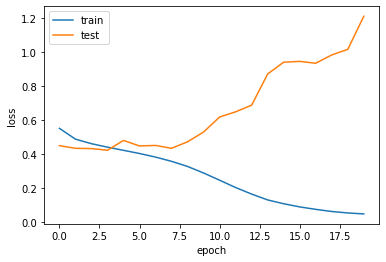

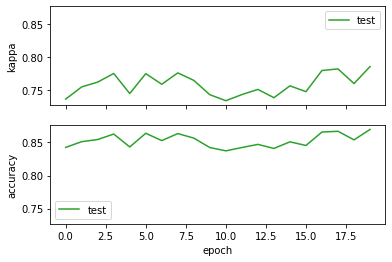

In [9]:
# Loss history
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

# Kappa and accuracy history
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
ax1.plot(kappa_history, color='C2', label='test')
ax1.set_ylabel('kappa')
ax1.legend()
ax2.plot(accuracy_history, color='C2', label='test')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend()
fig.show()

###### Ideas

- Use ideas from previous sections, e.g. add the spectrogram of the vector magnitude signal.
- Transfer learning: consider grabbing [available](https://pytorch.org/docs/stable/torchvision/models.html) pre-trained image recognition models and adapting them to our task.

###### References

- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)
- [PyTorch's Conv2d module](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
- [Spotify's recommender system](https://benanne.github.io/2014/08/05/spotify-cnns.html)